# предсказание рукописного ввода цифр методом классификации гистограммы градиентов (HOG)

ДАНИЛЬЧЕНКО ВАДИМ

#### Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

-------------------------------------------------------------------------------------------------------------------------------

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
test_label = test[:, 0]
# приводим размерность к удобному для обработки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

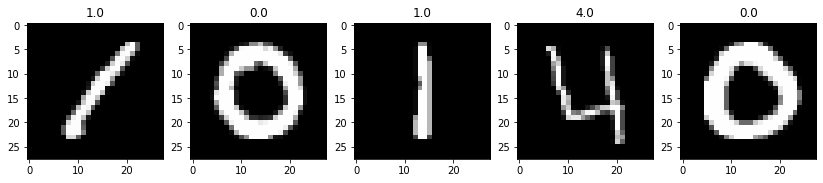

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [170]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=1)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=1)

In [171]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=1)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=1)

## Вычисляем угол и длину вектора градиента

In [172]:
# насколько понимаю train_g - магнитуда градиента (длина), а train_theta - направление градиента (угол)
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
train_sobel_x=None
train_sobel_y=None

In [173]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)
test_sobel_x=None
test_sobel_y=None

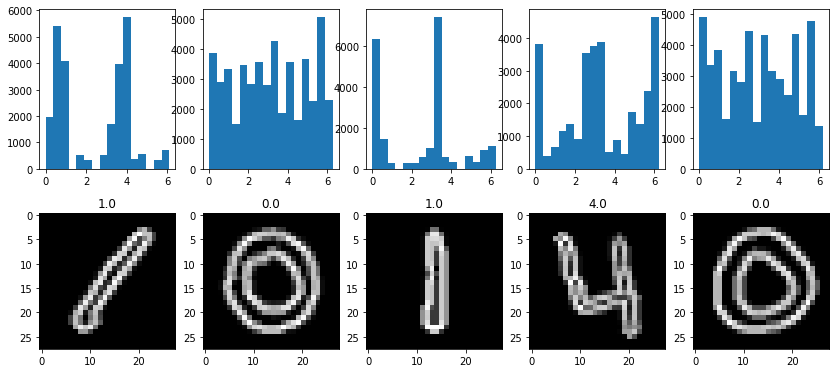

In [174]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

In [212]:
train_theta.shape

(42000, 28, 28)

## Вычисляем гистограммы градиентов

In [220]:
np.histogram(train_theta[1],bins=16,range=(0., 2. * np.pi),weights=train_g[1])

(array([3885.27942444, 2891.28012573, 3329.62884552, 1487.30846804,
        3475.59588513, 3115.62524159, 3655.91332609, 2438.78192857,
        4272.06913976, 2565.04834444, 3144.85260027, 1346.8836959 ,
        3859.21063786, 2411.20424682, 4749.63442346, 2309.91291699]),
 array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633,
        1.96349541, 2.35619449, 2.74889357, 3.14159265, 3.53429174,
        3.92699082, 4.3196899 , 4.71238898, 5.10508806, 5.49778714,
        5.89048623, 6.28318531]))

In [221]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 64))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist
    borders=None

In [222]:
test_hist = np.zeros((len(test_img), 64))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist
    borders=None

## Нормируем вектор гистограммы

In [223]:
#  объединим гистограммы, нормируем и затем разделим обратно
total_hist=np.concatenate([train_hist,test_hist])

In [224]:
total_hist = total_hist / np.linalg.norm(total_hist, axis=1)[:, None]
train_hist=total_hist[:train_hist.shape[0]]
test_hist=total_hist[train_hist.shape[0]:]
total_hist=None

## обучим классификатор

In [225]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf=RandomForestClassifier(max_depth=15, random_state=119, n_estimators=96, n_jobs=-1)
rf.fit(X=train_hist, y=train_label)
y_train_pred=rf.predict(X=train_hist)
y_test_pred=rf.predict(X=test_hist)

## Оцениваем качество решения на валидационной выборке

In [226]:
from sklearn.metrics import accuracy_score
print(f'accuracy train: {accuracy_score(y_true=train_label, y_pred=y_train_pred)}')

accuracy train: 0.9925952380952381


In [227]:
from sklearn.metrics import classification_report
print(classification_report(train_label, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4132
         1.0       1.00      1.00      1.00      4684
         2.0       1.00      0.98      0.99      4177
         3.0       0.96      1.00      0.98      4351
         4.0       1.00      1.00      1.00      4072
         5.0       0.99      0.99      0.99      3795
         6.0       1.00      0.99      1.00      4137
         7.0       1.00      1.00      1.00      4401
         8.0       0.99      0.99      0.99      4063
         9.0       1.00      0.99      1.00      4188

    accuracy                           0.99     42000
   macro avg       0.99      0.99      0.99     42000
weighted avg       0.99      0.99      0.99     42000



In [228]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(train_label, y_train_pred))

[[4090    1    1   29    1    2    2    0    5    1]
 [   0 4681    0    1    1    0    1    0    0    0]
 [  13    0 4091   47    0   11    7    0    6    2]
 [   5    0    0 4332    0    6    0    0    8    0]
 [   3    0    0    1 4066    0    2    0    0    0]
 [   4    0    0   28    0 3758    0    0    5    0]
 [   2    0    1   15    1    1 4114    0    3    0]
 [   0    0    1    3    0    2    0 4393    1    1]
 [   0    1    2   47    0    7    0    0 4006    0]
 [   0    0    2   16    1    0    1    0   10 4158]]


## Визуализируем предсказания

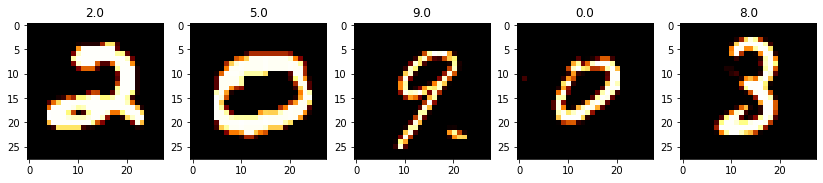

In [233]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='afmhot');
    subplot.set_title('%s' % y_test_pred[i-1]);

результаты на тестовой выборке на первый взгляд не очень, а ведь на тренировочной почти 100% тоноть - видимо модель переобучилась, посмотрим на результат kaggle

## Готовим файл для отправки

In [234]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_test_pred, 1):
        dst.write('%s,%s\n' % (i, p))